## Extraction/identification of major topics & themes discussed in news articles.

- Topic modelling is an approach to discover abstract topics present in a corpus of text documents using Natural Language Processing(NLP) and Clustering techniques.

- The dataset consists of a collection of news articles from BBC News which belong one of five topics, business, entertainment, politics, sports and technology. The objective is to build an unsupervised machine learning model to identify hidden topics from news articles.

- The procedure to complete this task starts from data preprocessing where all the text documents are aggregated from different topics to create a single dataset and duplicates are removed, data exploration, data cleaning such as removal of stop-words, short-length words, special characters and other unnecessary elements from texts, Lemmatization to reduce words to their root form, Vectorization and finally modelling using clustering algorithms such as Latent Dirichlet Allocation(LDA) and Latent Semantic Analysis(LSA).

### Problem Description

- In this project your task is to identify major themes/topics across a collection of BBC news articles. You can use clustering algorithms such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) etc.

### Data Description

- The dataset contains a set of news articles for each major segment consisting of business, entertainment, politics, sports and technology. You need to create an aggregate dataset of all the news articles and perform topic modeling on this dataset. Verify whether these topics correspond to the different tags available.

In [1]:
!pip install pyLDAvis -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 17.7 MB/s eta 0:00:00


In [2]:
path = 'https://frenzy86.s3.eu-west-2.amazonaws.com/python/bbc-text.csv'

In [123]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import gensim
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [124]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
import pandas as pd
df= pd.read_csv(path)
df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [18]:
#Shape of dataframe
df.shape

(2225, 2)

In [19]:
df.describe().T

,count,unique,top,freq
category,2225,5,sport,511
text,2225,2126,kennedy questions trust of blair lib dem leade...,2


In [20]:
#removing duplicates
print(len(df[df['text'].duplicated()]))
df=df.drop_duplicates('text')

99


In [21]:
#new shape of data frame
df.shape

(2126, 2)

In [22]:
#different type of articles
print(df['text'].unique())

['tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to hig

* The dataset consist of 2225 rows and 2 columns (text,type)
* The news articles are of 5 unique types.
* The dataset has no null values but it has 98 duplicate news articles.
* The new shape of the dataset is 2127 rows with 2 columns after removal of duplicates

###Feature engineering

In [23]:
#length of the news
df['length']=df['text'].str.len()

In [24]:
#function to count the number of words in the article
def word_count(article):
    return len(article.split(" "))

In [25]:
# Getting word count of each article
df['word_count']=df['text'].apply(word_count)

In [26]:
#Description of these new variable
df.describe()

,length,word_count
count,2126.000000,2126.000000
mean,2262.765287,420.041392
std,1382.011347,263.630662
min,501.000000,94.000000
25%,1437.500000,267.000000
50%,1956.500000,360.000000
75%,2801.500000,514.000000
max,25483.000000,4759.000000


In [29]:
#Total number of words present in the whole corpus
Total_words=sum(df['word_count'])
Total_words

893008

In [30]:
# Percentage of Types of news in the dataset
df['category'].value_counts(normalize=True)*100

category
sport            23.706491
business         23.659454
politics         18.955786
entertainment    17.356538
tech             16.321731
Name: proportion, dtype: float64

[Text(0.5, 1.0, 'Count of different types of news articles')]

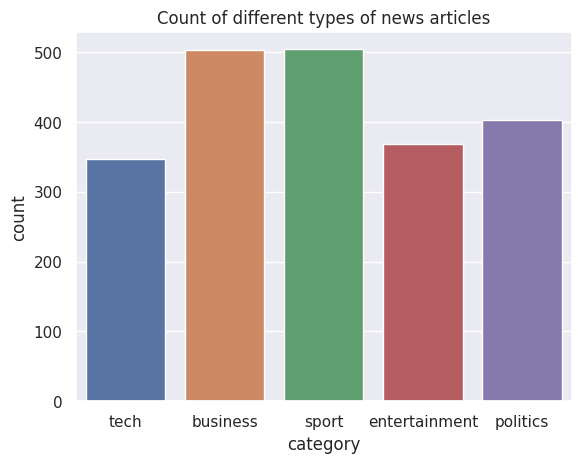

In [122]:
#Countplot of different types of Articles in the dataset
sns.countplot(x=df['category'],hue=df['category']).set(title='Count of different types of news articles')

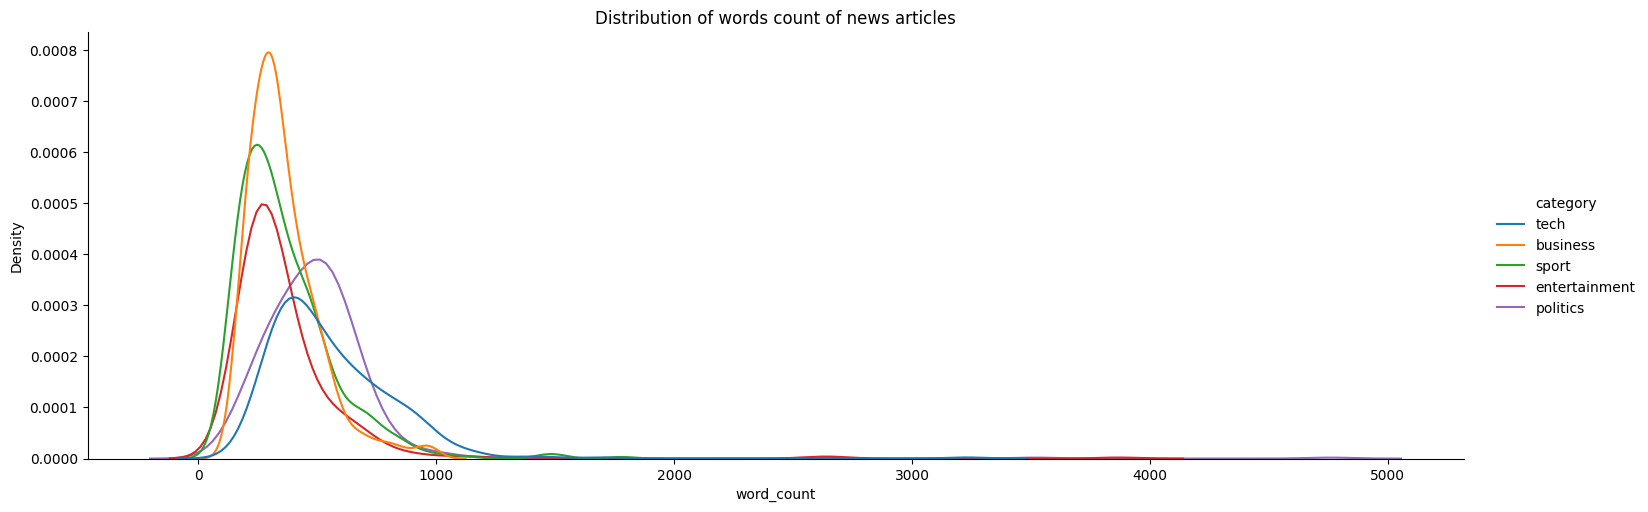

In [33]:
#distribution of word counts of different news type
sns.displot(df, x="word_count", hue="category", kind="kde",height=5,aspect =3 ).set(title='Distribution of words count of news articles')

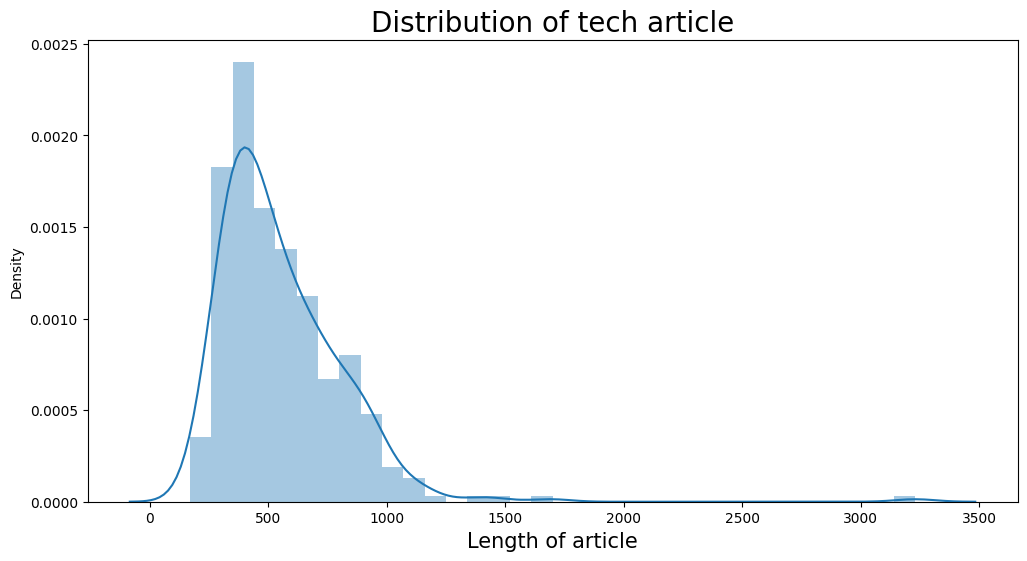

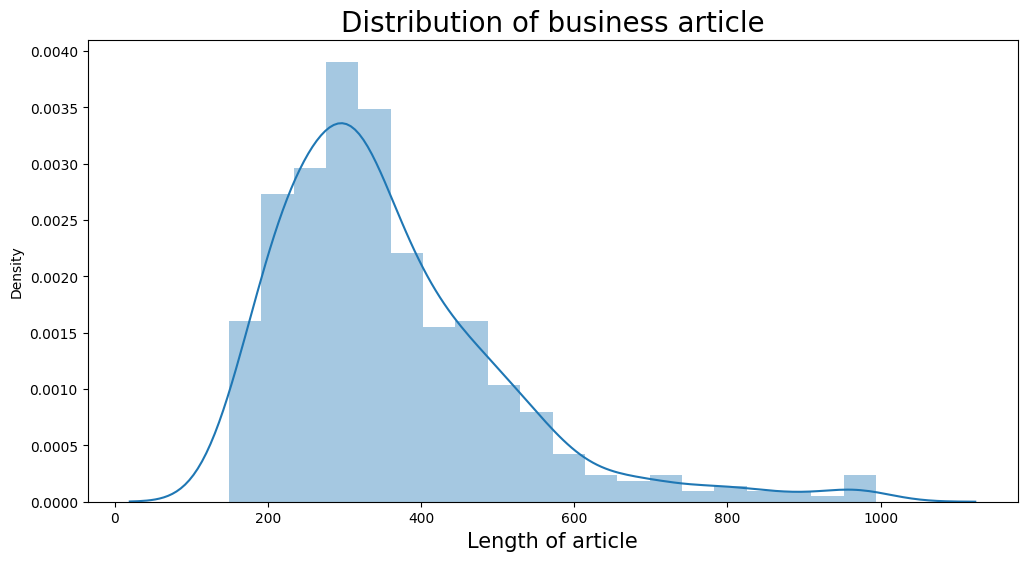

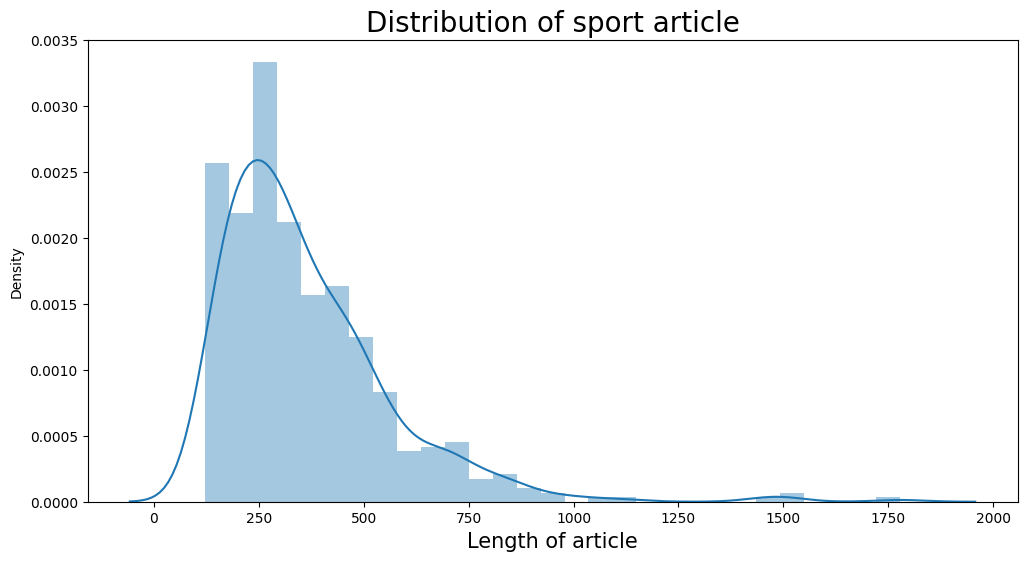

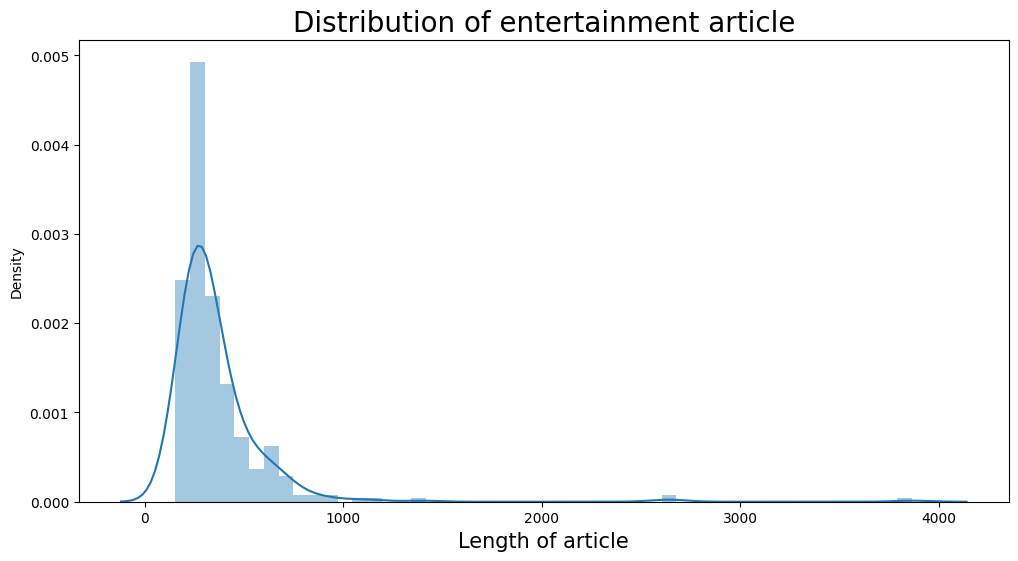

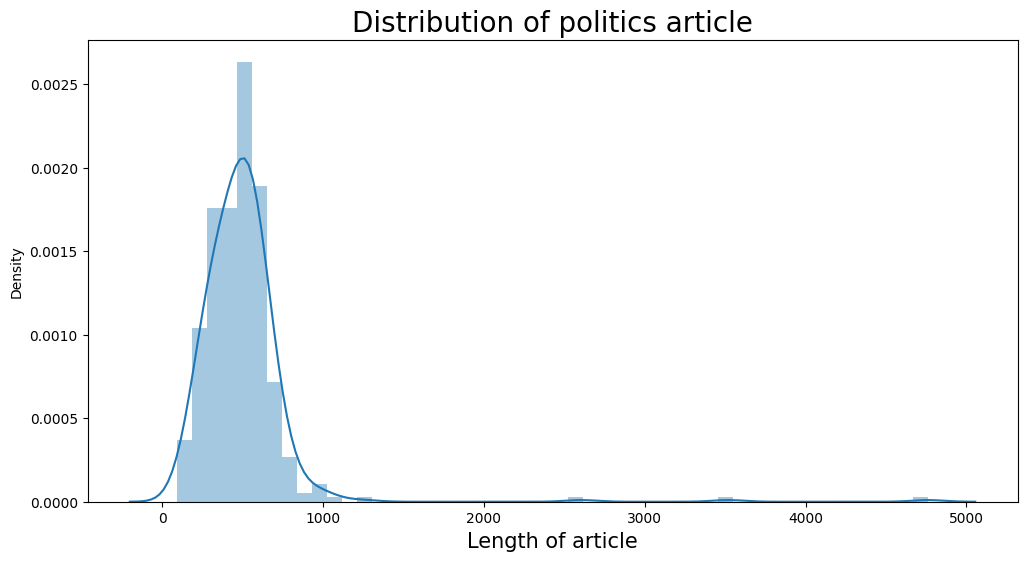

In [34]:
#Distribution of different types of articles
types_article=list(df['category'].unique())
for article in types_article:
    df_article=df[df['category']==article]
    plt.figure(figsize=(12,6))
    fig=sns.distplot(x=df_article['word_count'])
    fig.set_title(f'Distribution of {article} article',size=20)
    fig.set_xlabel('Length of article',size=15)

* Topics Business and Sports have more number of news articles in the dataset.
* Business has more aritlces of lesser word-counts.
* Politics and Entertainment articles are bigger than any other topic.
* The curve shows most of the articles are of length 500 words approx.


###Data preprocessing

In [35]:
#copying the original data
corpus_df=df.copy(deep=True)

In [37]:
#First observation
obs=df['text'][0]
obs

'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high

* The above article has <b>punctuation, numericals , special characters and new line character </b>.  These are needed to be cleaned for further processing

In [40]:
#Data preprocessing on a random observation
#Removal of newline character
obs=obs.replace('\\n'," ")
#Removal of all the punctuations,special character, numbers
obs=re.sub("[^a-zA-Z]"," ",obs)
#conversion to lower case
obs=obs.lower()
#removal of additional whitespace
obs=re.sub(r'\s+'," ",obs)
#After basic cleaning
obs

'tv future in the hands of viewers with home theatre systems plasma high definition tvs and digital video recorders moving into the living room the way people watch tv will be radically different in five years time that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes with the us leading the trend programmes and other content will be delivered to viewers via home networks through cable satellite telecoms companies and broadband service providers to front rooms and portable devices one of the most talked about technologies of ces has been digital and personal video recorders dvr and pvr these set top boxes like the us s tivo and the uk s sky system allow people to record store play pause and forward wind tv programmes when they want essentially the technology allows for much more personalised tv they are also being built in to high definition tv sets which a

A basic cleaning has been performed . Now Applying this one whole data

In [41]:
#Function to perform cleaning or preprocessing of articles
def cleaning(text):
    cleaned_text = text.replace('\\n'," ")                              # removal of new line symbol \n
    cleaned_text = re.sub("[^a-zA-Z]"," ",cleaned_text)                 # removal of all the punctuations,special character, numbers
    cleaned_text = cleaned_text.lower()                                 # converting to lower case
    cleaned_text = re.sub(r'\s+'," ",cleaned_text)                      # Removal of additional white space
    return cleaned_text

In [42]:
#Applying basic cleaning to whole data
corpus_df['text']=corpus_df['text'].apply(cleaning)

In [43]:
#Word Count after basic cleaning
corpus_df['wc_after_cleaning']=corpus_df['text'].apply(word_count)

In [45]:
corpus_df

,category,text,length,word_count,wc_after_cleaning
0,tech,tv future in the hands of viewers with home th...,4333,806,745
1,business,worldcom boss left books alone former worldcom...,1842,332,297
2,sport,tigers wary of farrell gamble leicester say th...,1342,270,248
3,sport,yeading face newcastle in fa cup premiership s...,2176,390,346
4,entertainment,ocean s twelve raids box office ocean s twelve...,1579,287,262
...,...,...,...,...,...
2220,business,cars pull down us retail figures us retail sal...,1745,328,274
2221,politics,kilroy unveils immigration policy ex chatshow ...,955,164,156
2222,entertainment,rem announce new glasgow concert us band rem h...,1648,314,296
2223,politics,how political squabbles snowball it s become c...,4684,912,847


####Lemmatization

In [47]:
#Lemmatization
from nltk.stem import WordNetLemmatizer

def lemmatize_word(text):
    word_list = word_tokenize(text)
    lemma = WordNetLemmatizer()
    word_list = [lemma.lemmatize(word) for word in word_list]
    # list to sentence
    return ' '.join(word_list)

In [48]:
#Applying lemmatization
corpus_df['text']=corpus_df['text'].apply(lemmatize_word)

[Text(0.5, 1.0, 'Top 20 most frequent words in the corpus')]

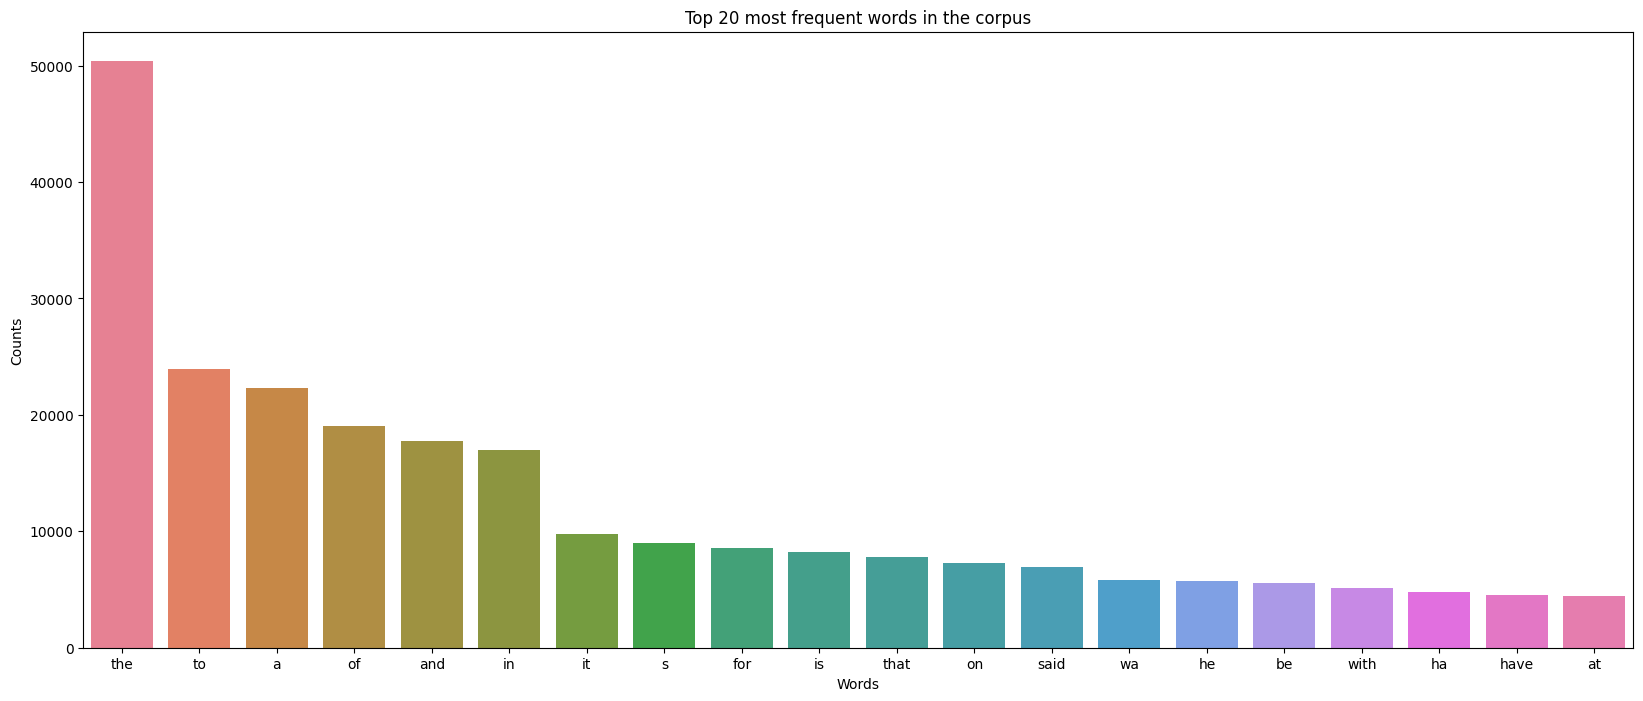

In [50]:
#Top 20 most frequent words in the corpus
Top_20_freq = pd.Series(' '.join(corpus_df['text']).split()).value_counts()[:20]
top20=pd.DataFrame()
top20['Words']= list(Top_20_freq.index)
top20['Counts']=list(Top_20_freq.values)

fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(x = 'Words',y = 'Counts',data = top20,ax=ax,hue='Words').set(title='Top 20 most frequent words in the corpus')

* The graph shows that stopwords are most frequent in the whole dataset. So these stopwords need to be removed.
*Also the short length (< 3) words are most frequent.

In [52]:
#Removing short length words ( length less than 3)
def short_length(text):
  return (' '.join([wds for wds in text.split() if len(wds)>2]))

corpus_df['text']=corpus_df['text'].apply(short_length)

In [53]:
#Word count after removal of short length
corpus_df['wc_rem_short_len']=corpus_df['text'].apply(word_count)

In [55]:
corpus_df

,category,text,length,word_count,wc_after_cleaning,wc_rem_short_len
0,tech,future the hand viewer with home theatre syste...,4333,806,745,589
1,business,worldcom bos left book alone former worldcom b...,1842,332,297,226
2,sport,tiger wary farrell gamble leicester say they w...,1342,270,248,192
3,sport,yeading face newcastle cup premiership side ne...,2176,390,346,273
4,entertainment,ocean twelve raid box office ocean twelve the ...,1579,287,262,206
...,...,...,...,...,...,...
2220,business,car pull down retail figure retail sale fell j...,1745,328,274,216
2221,politics,kilroy unveils immigration policy chatshow hos...,955,164,156,126
2222,entertainment,rem announce new glasgow concert band rem have...,1648,314,296,234
2223,politics,how political squabble snowball become commonp...,4684,912,847,645


####Removing Stopwords

In [56]:
#Stopwords
# list of stopwords from nltk
stopwords_nltk = list(stopwords.words('english'))
# list of stopwords from spacy
sp = spacy.load('en_core_web_sm')
stopwords_spacy = list(sp.Defaults.stop_words)
# list of stopwords from gensim
stopwords_gensim = list(gensim.parsing.preprocessing.STOPWORDS)
# unique stopwords from all stopwords
all_stopwords = []
all_stopwords.extend(stopwords_nltk)
all_stopwords.extend(stopwords_spacy)
all_stopwords.extend(stopwords_gensim)

# all unique stop words
all_stopwords = list(set(all_stopwords))

def stop_words(text):
  text = [wd.lower() for wd in text.split() if wd.lower() not in all_stopwords]
  return " ".join(text)

In [57]:
len(all_stopwords)

412

In [60]:
#Removal of Stopwords
corpus_df['text']=corpus_df['text'].apply(stop_words)

In [61]:
# word count after removing the stopwords
corpus_df['after_stop']=corpus_df['text'].apply(word_count)

In [62]:
corpus_df

,category,text,length,word_count,wc_after_cleaning,wc_rem_short_len,after_stop
0,tech,future hand viewer home theatre plasma high de...,4333,806,745,589,337
1,business,worldcom bos left book worldcom bos bernie ebb...,1842,332,297,226,150
2,sport,tiger wary farrell gamble leicester rushed mak...,1342,270,248,192,104
3,sport,yeading face newcastle cup premiership newcast...,2176,390,346,273,223
4,entertainment,ocean raid box office ocean crime caper sequel...,1579,287,262,206,149
...,...,...,...,...,...,...,...
2220,business,car pull retail figure retail sale fell januar...,1745,328,274,216,157
2221,politics,kilroy unveils immigration policy chatshow hos...,955,164,156,126,90
2222,entertainment,rem announce new glasgow concert band rem anno...,1648,314,296,234,153
2223,politics,political squabble snowball commonplace argue ...,4684,912,847,645,339


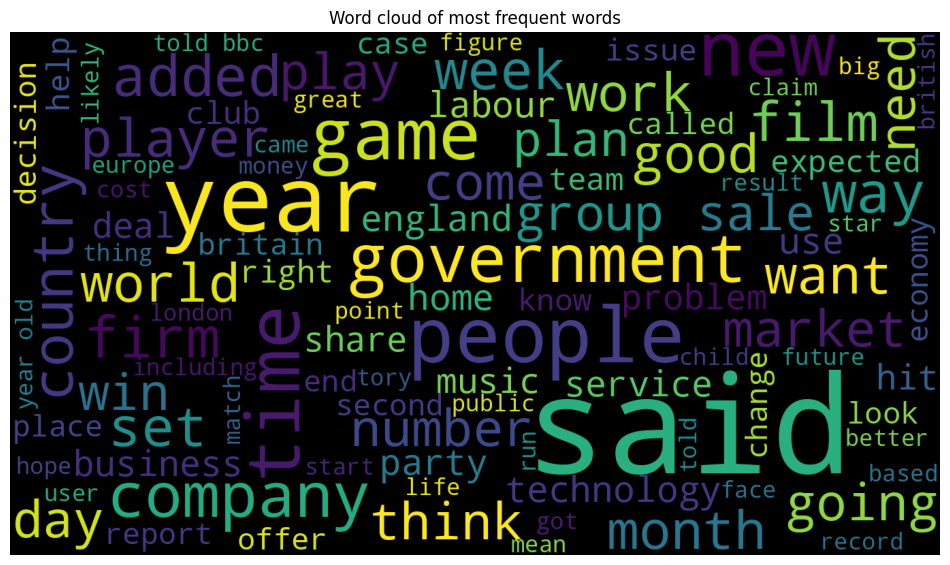

In [63]:
# Cloud Words plot for displaying most frequent words in the data
freq_words = ','.join(list(corpus_df['text'].values))

wordcloud = WordCloud(width=1366, height=768, random_state=21,max_words=100 ,max_font_size=200,background_color='black').generate(freq_words)
plt.figure(figsize=(12, 7))
plt.imshow(wordcloud)
plt.title('Word cloud of most frequent words')
plt.axis('off')
plt.show()

In [64]:
#removal of non-contextual words
add_stopwords= ['said','told','called','use','know','came','based','way','added','including','got']

In [65]:
#Function to remove additional stopwords
def remove_add_stopwords(text):
  text = [wd.lower() for wd in text.split() if wd.lower() not in add_stopwords]
  return " ".join(text)


In [67]:
#Removing addtional stopwords according to use case
corpus_df['text']=corpus_df['text'].apply(remove_add_stopwords)

In [68]:
# word count after removing the additional stopwords
corpus_df['wc_rem_stopword']=corpus_df['text'].apply(word_count)

In [70]:
corpus_df

,category,text,length,word_count,wc_after_cleaning,wc_rem_short_len,after_stop,wc_rem_stopword
0,tech,future hand viewer home theatre plasma high de...,4333,806,745,589,337,328
1,business,worldcom bos left book worldcom bos bernie ebb...,1842,332,297,226,150,148
2,sport,tiger wary farrell gamble leicester rushed mak...,1342,270,248,192,104,100
3,sport,yeading face newcastle cup premiership newcast...,2176,390,346,273,223,223
4,entertainment,ocean raid box office ocean crime caper sequel...,1579,287,262,206,149,148
...,...,...,...,...,...,...,...,...
2220,business,car pull retail figure retail sale fell januar...,1745,328,274,216,157,153
2221,politics,kilroy unveils immigration policy chatshow hos...,955,164,156,126,90,85
2222,entertainment,rem announce new glasgow concert band rem anno...,1648,314,296,234,153,152
2223,politics,political squabble snowball commonplace argue ...,4684,912,847,645,339,333


[Text(0.5, 1.0, 'Top 20 most frequent words in the corpus After stopword removal')]

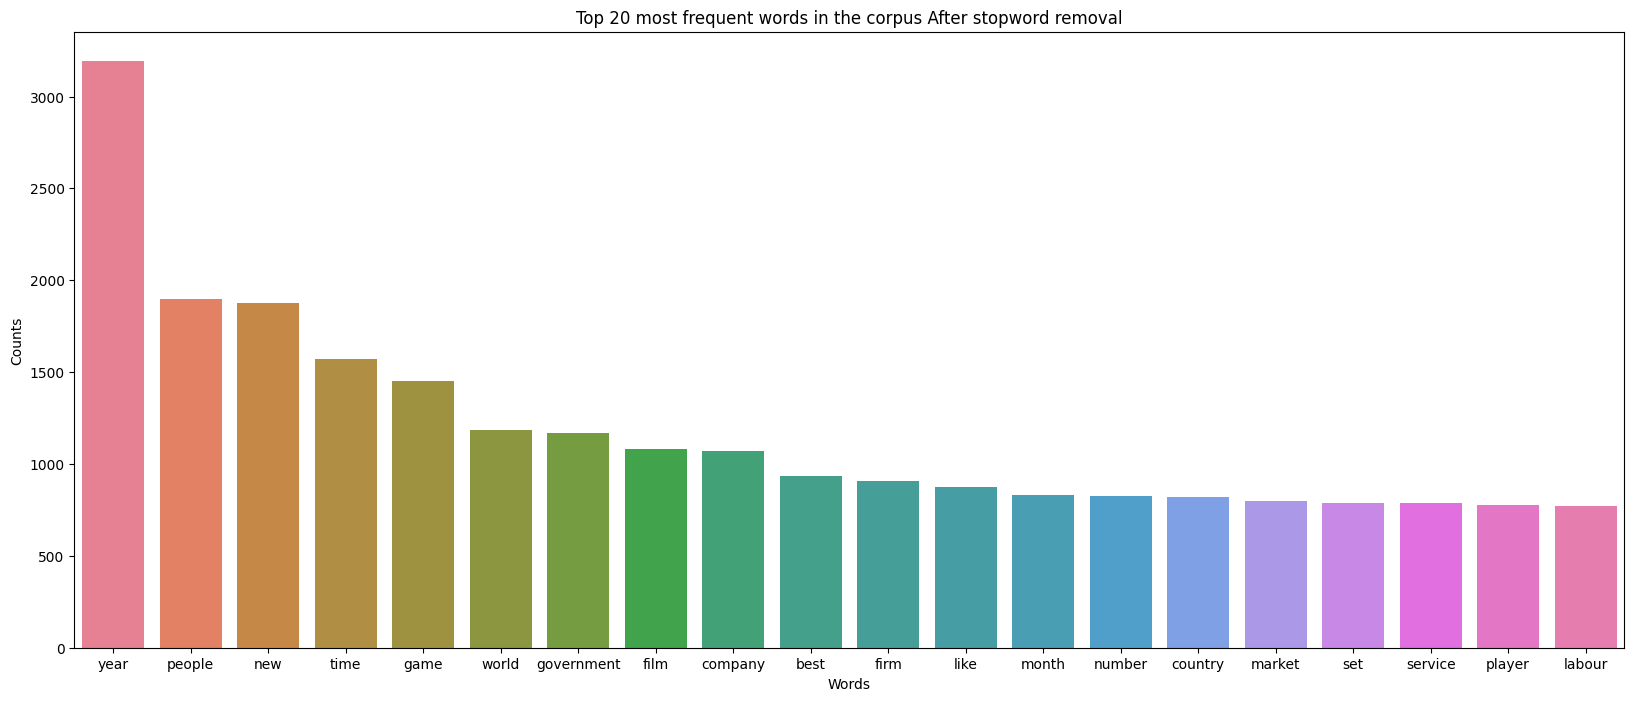

In [73]:
#Top 20 most frequent words in the corpus After stopword removal
Top_20_freq = pd.Series(' '.join(corpus_df['text']).split()).value_counts()[:20]
top20=pd.DataFrame()
top20['Words']= list(Top_20_freq.index)
top20['Counts']=list(Top_20_freq.values)

fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(x = 'Words',y = 'Counts',data = top20,ax=ax,hue='Words').set(title='Top 20 most frequent words in the corpus After stopword removal')

* After removing stopwords, the frequencies of contexual words are more apparent.

#### Visualization of top 20 bi-gram & tri-gram

In [74]:
def get_top_n_gram(corpus, ngram, n=20):

    '''
    This functions takes entire corpus and returns list of tuple in  pair words and number of its occurence.
    '''
    # creates instance of count vectorizer for n-grams
    vec = CountVectorizer(ngram_range=(ngram,ngram)).fit(corpus)
    # returns sparse matrix of index as documents and columns as Bow as features
    bag_of_words = vec.transform(corpus)
    # returns 2D array with count of features in corpus
    sum_words = bag_of_words.sum(axis=0)
    # returns list of tuples with text,counts pair
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    # sort the list of tuples by its number of occurence
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    # returns list of tuples top n words
    return words_freq[:n]

[Text(0.5, 1.0, 'Top 20 bigram words')]

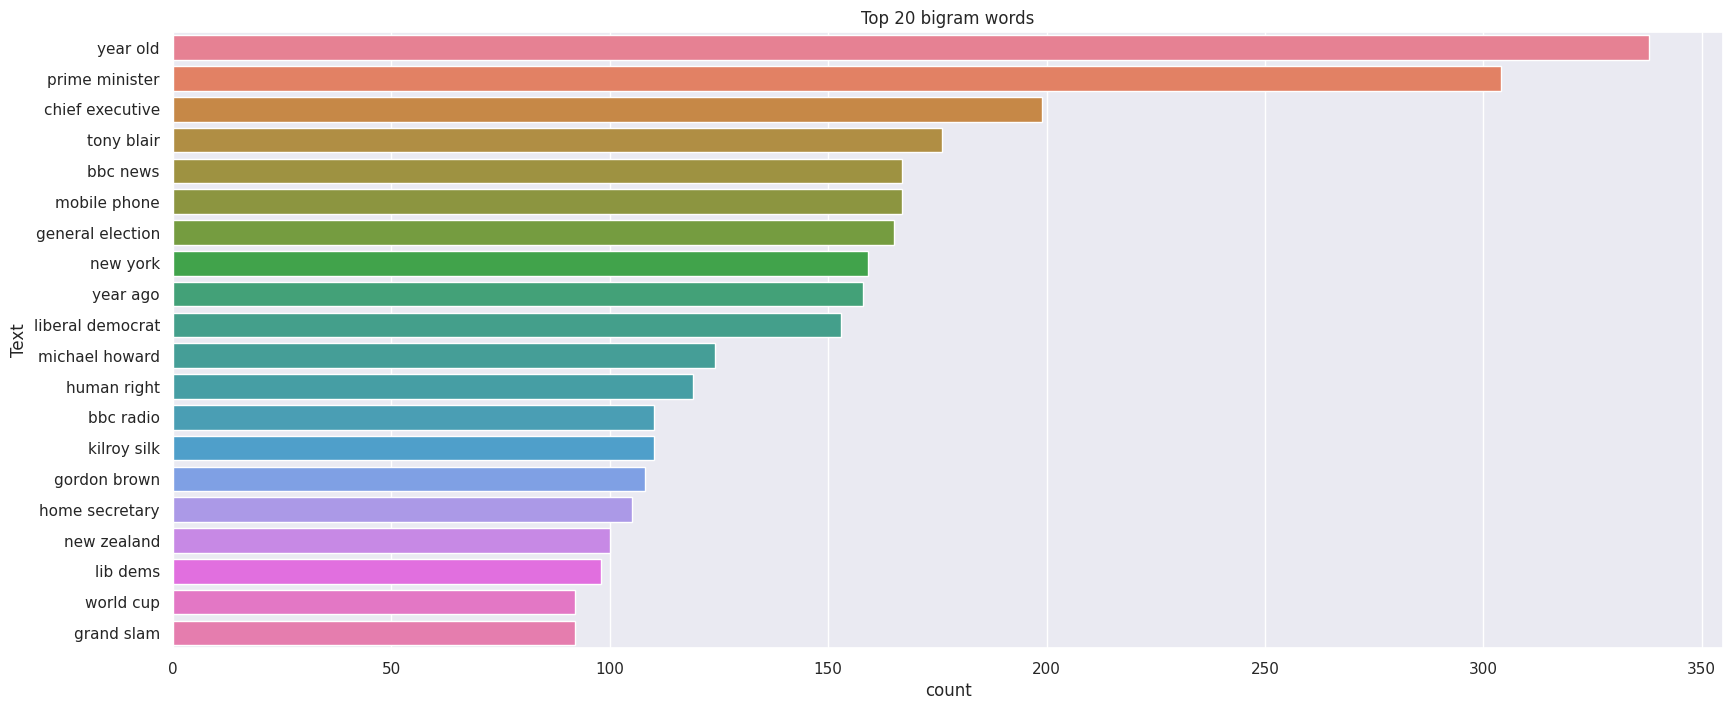

In [77]:
# get top 20 bigram words using function
common_words = get_top_n_gram(corpus_df['text'],ngram=2)
# creates dataframe from list of tuples
df1 = pd.DataFrame(common_words, columns = ['Text' , 'count'])

# plot top 20 words
sns.set(font_scale = 1)
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(y= 'Text',x = 'count',data = df1,ax=ax,hue='Text').set(title='Top 20 bigram words')

[Text(0.5, 1.0, 'Top 20 trigram words')]

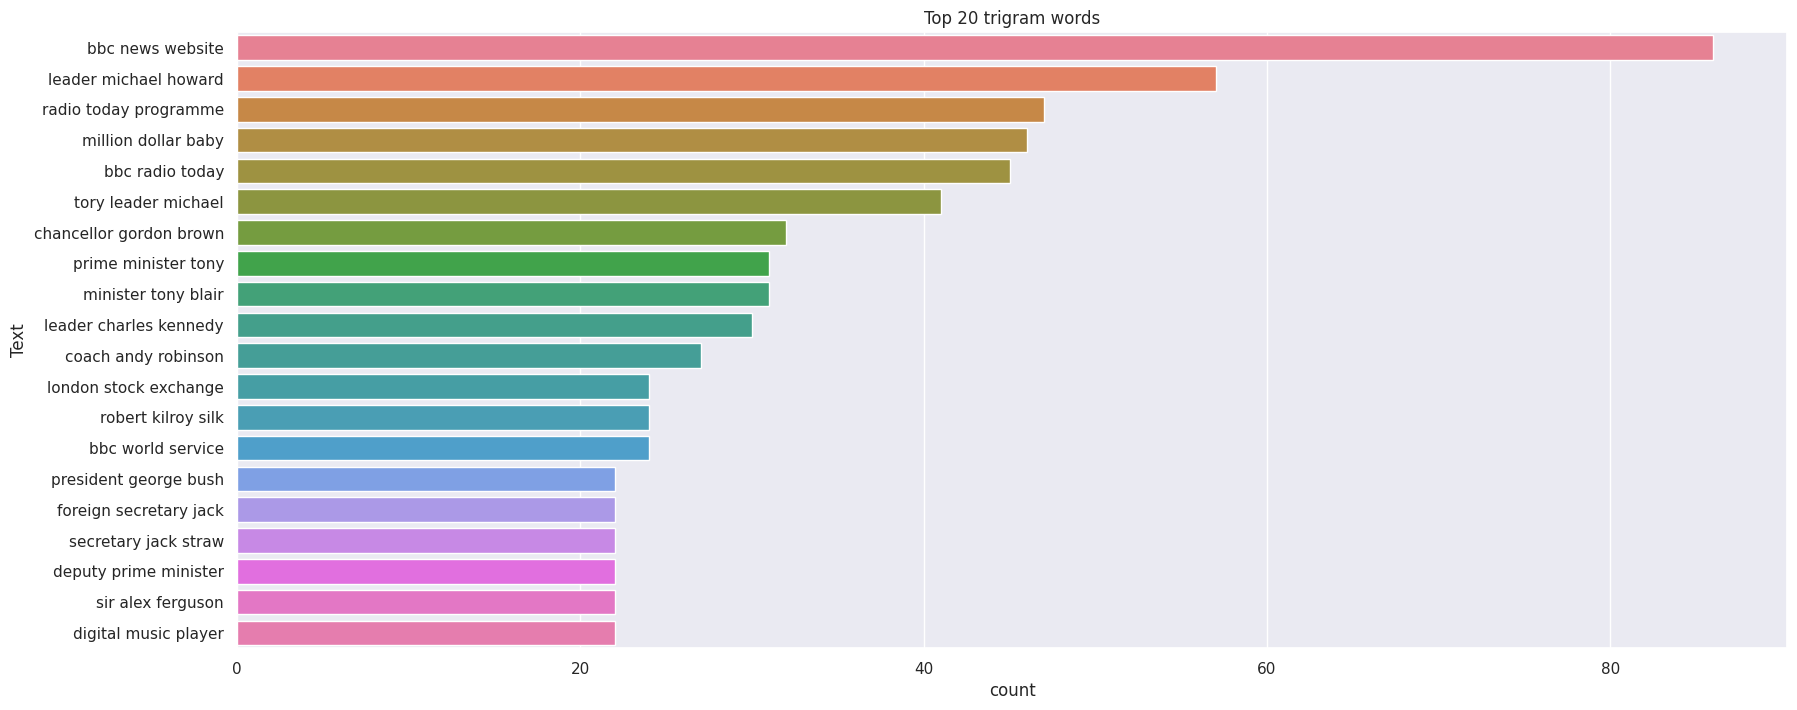

In [78]:
# get top 20 trigram words using function
common_words = get_top_n_gram(corpus_df['text'],ngram=3)
# creates dataframe from list of tuples
df2 = pd.DataFrame(common_words, columns = ['Text' , 'count'])
# plot top 20 words
sns.set(font_scale = 1)
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(y= 'Text',x = 'count',data = df2,ax=ax,hue='Text').set(title='Top 20 trigram words')

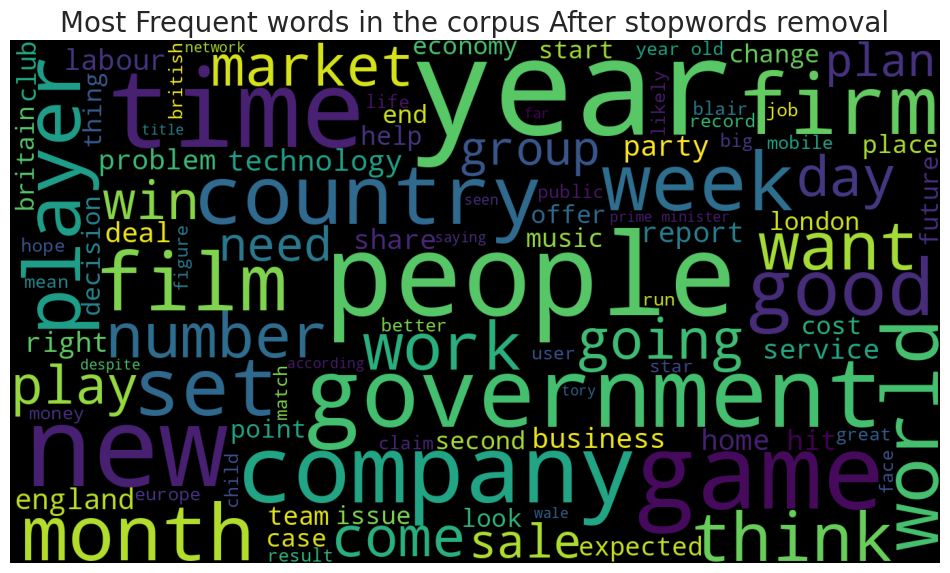

In [79]:
#Most Frequent words in the corpus
freq_words = ','.join(list(corpus_df['text'].values))

wordcloud = WordCloud(width=1366, height=768, random_state=42,max_words=100 ,max_font_size=200,background_color='black').generate(freq_words)
plt.figure(figsize=(12, 7))
plt.imshow(wordcloud)
plt.title('Most Frequent words in the corpus After stopwords removal',size=20)
plt.axis('off')
plt.show()

In [80]:
#Data reduction
after_preprocess=corpus_df['wc_rem_stopword'].sum()
after_preprocess

data_reduce=(after_preprocess/Total_words)*100
data_reduce

43.87172343360866

* Almost 50% of unneccessary data has been removed.

####LDA

In [81]:
#Tf-Idf vectoriser
vectorizer = TfidfVectorizer(min_df = 0.03)
document_term_matrix = vectorizer.fit_transform(corpus_df['text'])

In [82]:
#Shape of document term matrix
document_term_matrix.shape

(2126, 946)

In [83]:

# Parameters tuning using Grid Search
from sklearn.model_selection import GridSearchCV
grid_params = {'n_components' : list(range(5,10))}

# LDA model
lda_model = GridSearchCV(LatentDirichletAllocation(),param_grid=grid_params)
lda_model.fit(document_term_matrix)

# Best LDA model
best_lda_model = lda_model.best_estimator_

print("Best LDA model's params" , lda_model.best_params_)
print("Best log likelihood Score for the LDA model",lda_model.best_score_)
print("LDA model Perplexity on train data", best_lda_model.perplexity(document_term_matrix))

Best LDA model's params {'n_components': 5}
Best log likelihood Score for the LDA model -22741.00127857202
LDA model Perplexity on train data 1444.2713000027468


In [85]:
# LDA model fitting for best parameter
lda= LatentDirichletAllocation(n_components=5,
                               max_iter=100,
                               random_state=667,
                               n_jobs=-1
                               )
lda.fit(document_term_matrix)

LatentDirichletAllocation(max_iter=100, n_components=5, n_jobs=-1,
                          random_state=667)

In [86]:
# LDA model
top_lda=lda.fit_transform(document_term_matrix)

print(top_lda.shape)
print(top_lda)

(2126, 5)
[[0.90968168 0.02528563 0.02147634 0.02143444 0.02212191]
 [0.0303068  0.02885714 0.50339234 0.03059994 0.40684377]
 [0.02771258 0.02736212 0.02800008 0.88879235 0.02813287]
 ...
 [0.02888935 0.55783417 0.02940851 0.02928137 0.35458661]
 [0.02394628 0.02134961 0.89983291 0.02386306 0.03100813]
 [0.02922118 0.02920334 0.02931961 0.8827662  0.02948966]]


In [87]:
# composition of doc 0 for eg
print("Document 0: ")
for i,topic in enumerate(top_lda[0]):
    print("Topic ",i,": ",topic*100,"%")

Document 0: 
Topic  0 :  90.96816812870408 %
Topic  1 :  2.528562775558697 %
Topic  2 :  2.147633962742824 %
Topic  3 :  2.1434444871496874 %
Topic  4 :  2.2121906458447103 %


* The first document is more belonging to the Topic 1.

In [88]:
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()

lda_panel = pyLDAvis.lda_model.prepare(best_lda_model, document_term_matrix,vectorizer,mds='tsne')
lda_panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4     -31.712101 -84.310745       1        1  25.577694
0      48.009026 -55.350399       2        1  22.385603
2      92.369286  17.385210       3        1  21.159594
1      11.780349  51.749317       4        1  18.349300
3     -55.522987   0.258914       5        1  12.527810, topic_info=           Term       Freq      Total Category  logprob  loglift
327        film  60.000000  60.000000  Default  30.0000  30.0000
551      mobile  30.000000  30.000000  Default  29.0000  29.0000
67        award  35.000000  35.000000  Default  28.0000  28.0000
859  technology  29.000000  29.000000  Default  27.0000  27.0000
624       phone  29.000000  29.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
906       video  10.214135  19.300093   Topic5  -5.1019   1.4409
760    security   9.676333  19.975170   Topic5  -5.1560   1.3524
332        firm  11.808338  44.698081   Topic5  -4.9569   0.7461
188    consumer   9.392141  19.505947   Topic5  -5.1858   1.3464
173     company   9.509630  48.462459   Topic5  -5.1734   0.4487

[245 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2         1  0.147694   access
2         3  0.221541   access
2         5  0.590777   access
9         4  0.935633    actor
10        4  0.906999  actress
...     ...       ...      ...
943       1  0.344037     year
943       2  0.249130     year
943       3  0.106770     year
943       4  0.249130     year
943       5  0.047453     year

[573 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 2, 4])

In [92]:
# most important words for each topic
vocab = vectorizer.get_feature_names_out()

In [96]:
from wordcloud import WordCloud
# Generate a word cloud image for given topic
def word_cloud_lda(index):
    imp_words_topic=""
    comp=lda.components_[index]
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
    for word in sorted_words:
        imp_words_topic=imp_words_topic+" "+word[0]

    wordcloud = WordCloud(width=600, height=400,max_font_size=100).generate(imp_words_topic)
    plt.figure( figsize=(5,5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

* Tech

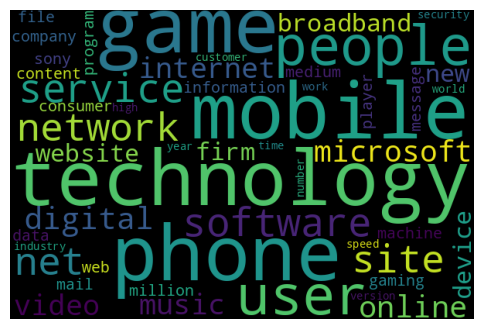

In [97]:
#Word Cloud for each topic # Tech
word_cloud_lda(0)

* Entertainment

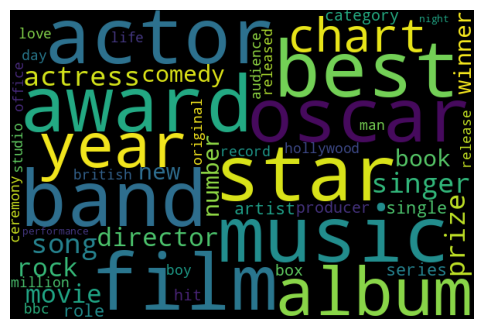

In [98]:
word_cloud_lda(1) #Entertainment

* Politics

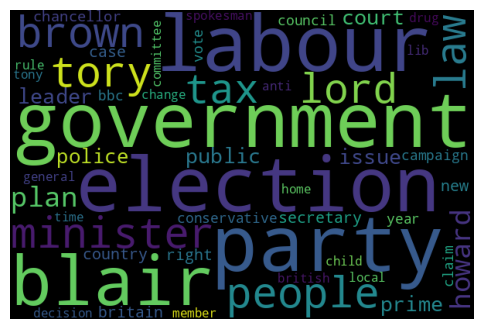

In [99]:
word_cloud_lda(2)  #Politics

* Business

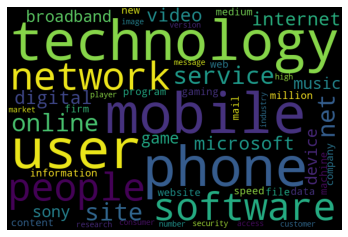

In [ ]:
word_cloud_lda(3)  #Business

* Sports

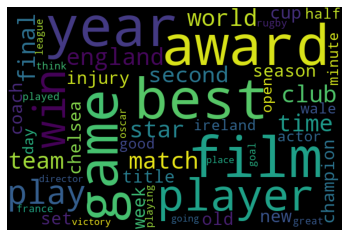

In [ ]:
word_cloud_lda(4) #Sport

####LSA

In [100]:
# create svd instance
svd_model = TruncatedSVD(n_components=5,random_state=42,algorithm='randomized')

# fit model to data
svd_model.fit(document_term_matrix)

tsvd_mat=svd_model.transform(document_term_matrix)

In [101]:
#Shape of truncated SVD
tsvd_mat.shape

(2126, 5)

In [105]:
#Using t-sne for transformation
tsne = TSNE(n_components=2)
tsne_mat = tsne.fit_transform(tsvd_mat)
tsne_mat

array([[-10.055839 ,  42.015602 ],
       [ 18.194847 ,  11.220914 ],
       [-28.405201 , -20.648832 ],
       ...,
       [ -7.8744354,   7.0288982],
       [ 17.526981 , -14.54418  ],
       [-30.621824 , -31.844357 ]], dtype=float32)

In [109]:
tsne_mat[:,0]

array([-10.055839 ,  18.194847 , -28.405201 , ...,  -7.8744354,
        17.526981 , -30.621824 ], dtype=float32)

<Axes: >

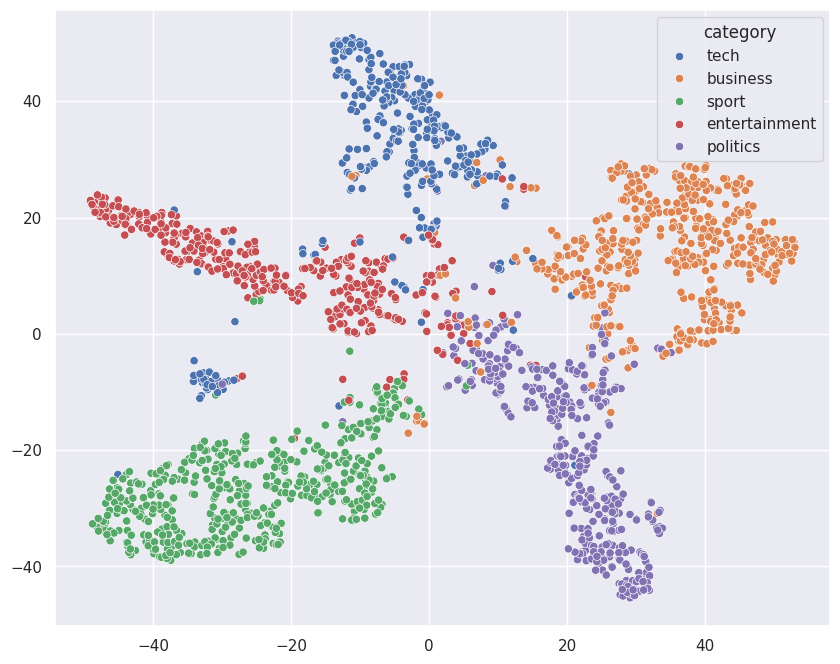

In [114]:
#Scatter plot of the topics using the t-sne in LSA
plt.figure(figsize=(10,8))
sns.scatterplot(x= tsne_mat[:,0],y=tsne_mat[:,1],hue=corpus_df['category'])

* The points of technology  & business clusters are scattered at different areas.

In [115]:
# Function to generate word cloud for each topic
def word_cloud_lsa(index):
    imp_words_topic=""
    comp=svd_model.components_[index]
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
    for word in sorted_words:
        imp_words_topic=imp_words_topic+" "+word[0]

    wordcloud = WordCloud(width=800, height=500).generate(imp_words_topic)
    plt.figure( figsize=(5,5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

* Tech

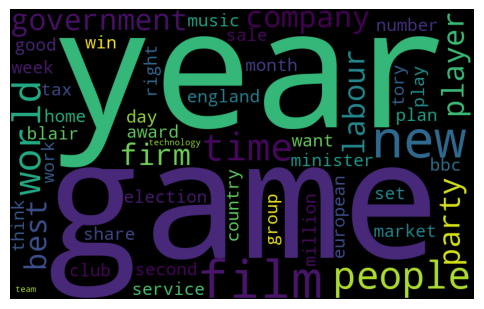

In [125]:
#Word Cloud for each topic using LSA
word_cloud_lsa(0)

* Entertainment

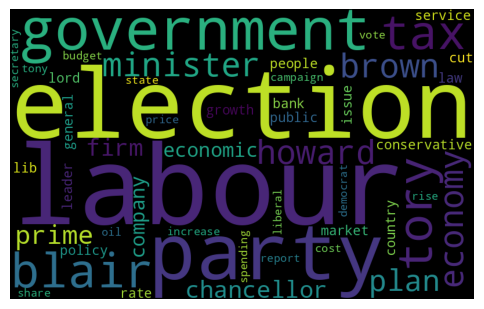

In [126]:
word_cloud_lsa(1)

* Politics

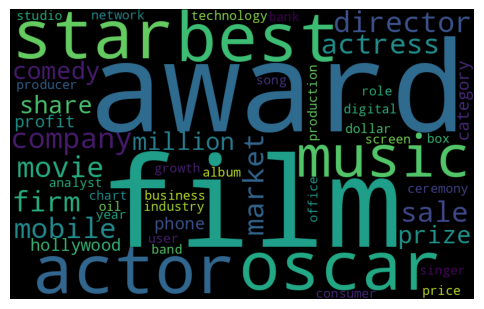

In [127]:
word_cloud_lsa(2)

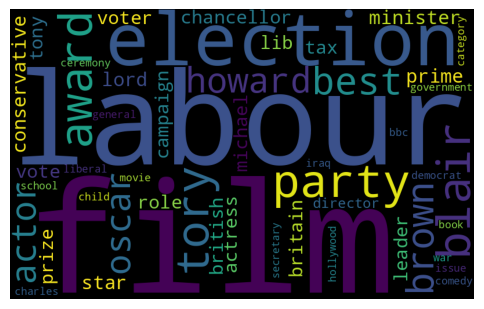

In [128]:
word_cloud_lsa(3)

* Business

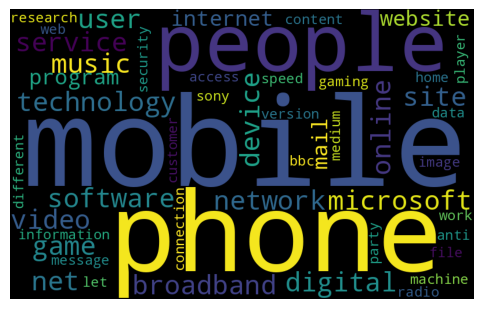

In [129]:
word_cloud_lsa(4)

* technology

##**Conclusion**

### * There are 5 different topic present in the aricles.
### * LDA and LSA are implemented to find the hidden topics.
### * LDA performs well & shows 5 different clusters present in the Corpus.
### * LSA also shows the 5 different clusters present in the scatterplot.
